<a href="https://colab.research.google.com/github/nithin-sudarsan/torchcodes/blob/chapter-1-pytorch-workflow/PyTorch_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prescribed steps
1. Find and prepare data
2. build a model (or use an already built model)
3. train the model with data
4. test the model (make predictions and evaluate model)
5. saving and loading the model for further use

## Import PyTorch and required packages

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.6.0+cu124'

## Find and prepare data
ML mainly has two parts to it
1. Find and prepare the data, by turning raw data into numbers
2. train a model to understand patterns in data or use an already existing model that might be able to best understand the pattern

### Create dummy data

In [2]:
weight = 0.7
bias = 0.3

x = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = x * weight + bias # similar to striaght line equation y = m * x + c
x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Train test split
80:20 train test split

In [3]:
train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split] # from starting up to train_split
x_test, y_test = x[train_split:], y[train_split:] # from train_split index up to end

len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

### Visualising the data

In [4]:
def plot_predictions(train_data = x_train,
                     train_labels = y_train,
                     test_data = x_test,
                     test_labels = y_test,
                     predictions = None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c='b', s=4, label = "Training Data")
  plt.scatter(test_data, test_labels, c='g', s=4, label = "Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label= "Predictions")

  plt.legend(prop={"size": 14})

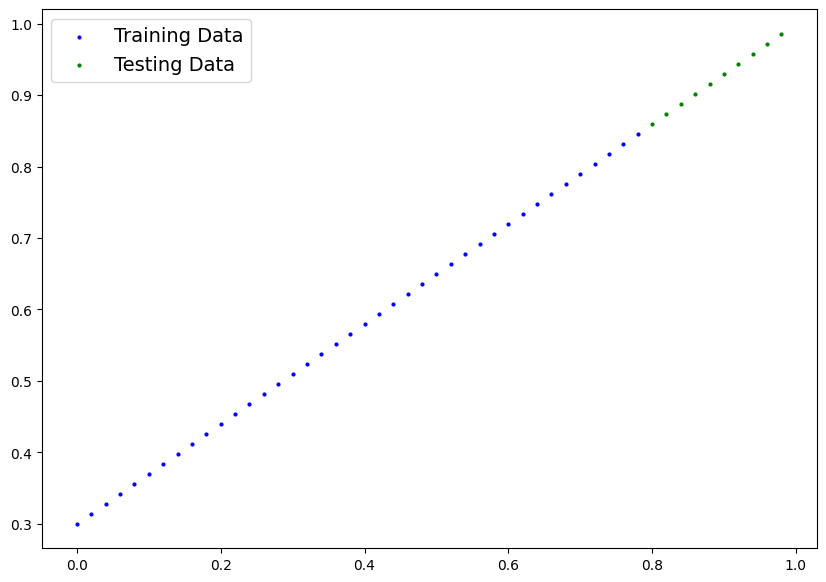

In [5]:
plot_predictions()

## Build the model
A model is built, trained on the blue dots from above to predict the green dots.

> I need to brush up my knowledge on OOPs in Python ( [Refer Link](https://realpython.com/python3-object-oriented-programming/)])


In [6]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1,
                                           dtype = torch.float32,
                                           requires_grad=True)) # allowed to update using gradient descent
    self.bias = nn.Parameter(torch.rand(1,
                                        dtype=torch.float32,
                                        requires_grad = True))
  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

Important modules
1. torch.nn
2. torch.nn.Parameter
3. torch.nn.Module
4. torch.optim
5. def forward


We can check the parameters used in a model and their properties using `model.parameters()` method.

In [7]:
torch.manual_seed(42)

model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

We can also do this using `model.state_dict()`

In [8]:
model0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

### Making predictions

In [9]:
with torch.inference_mode():
  y_pred = model0(x_test)

`torch.inference_mode()` is used when using the models to make predictions. This mode turns off unwanted compute energy including the needed to track the gradient and this in turn helps running the forward pass faster.

In [10]:
y_pred

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

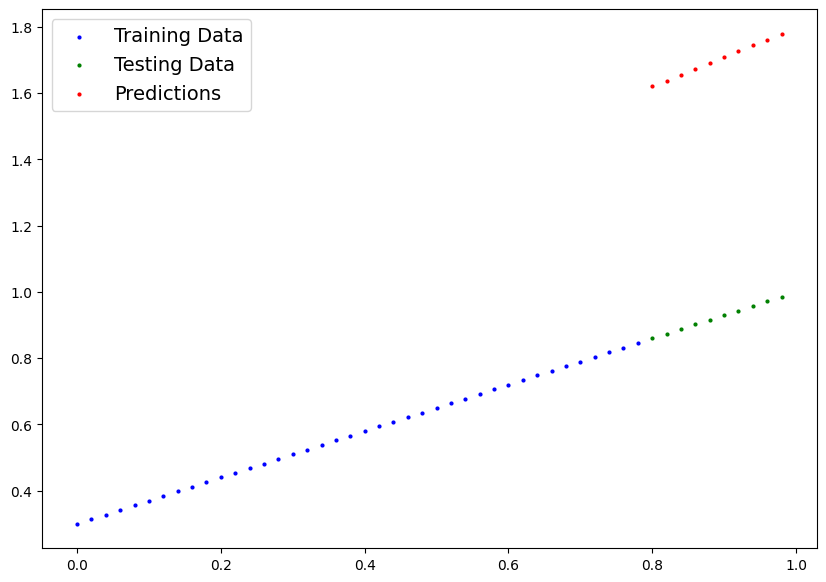

In [11]:
plot_predictions(predictions=y_pred)

In [12]:
y_test - y_pred

tensor([[-0.7608],
        [-0.7645],
        [-0.7681],
        [-0.7718],
        [-0.7754],
        [-0.7790],
        [-0.7827],
        [-0.7863],
        [-0.7900],
        [-0.7936]])

we can see from the above graph and the error valyes that a model with the initialisde random values for weights and biases, without being trained is not performing well. I'm gonna train it on `x_train` and test once again.

## Training the model
In this example since we already know that the weights is 0.7 and the bias is 0.3, if we hardcode these values it should predict with absolutely no errors. This can be done as follows

In [13]:
with torch.no_grad():
  model0.weights.copy_(torch.tensor([0.7], dtype=torch.float32))
  model0.bias.copy_(torch.tensor([0.3], dtype = torch.float32))

In [14]:
model0.weights, model0.bias

(Parameter containing:
 tensor([0.7000], requires_grad=True),
 Parameter containing:
 tensor([0.3000], requires_grad=True))

In [15]:
with torch.inference_mode():
  y_pred = model0(x_test)

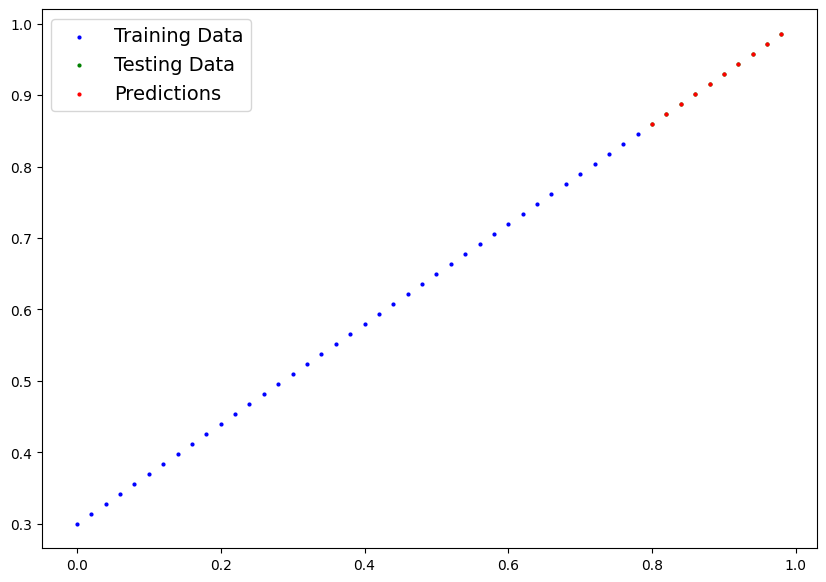

In [16]:
plot_predictions(predictions=y_pred)

But out main intension is to train the machine learning model to learn from the training data and see what values / patterns of weights and biases it learns from the traning data.

In order to train the model we need loss functions and optimizers.
- **Loss function** says how much different our predictions are off from the actual values<br>
  Some examples are
  - **Mean Absolute Error (MAE)**: for regression problems [`torch.nn.L1Loss()`]
  - **Binary Cross Entropy** for classification problems [`torch.nn.BCELoss()`]
- **Optimizer** tells the model what is the best way to update the parameters in order to lower the loss.<br>
  Some examples are
  - **Adam Optimizer** [`torch.optim.Adam()`]
  - **Stochastic Gradient Descent** [`torch.optim.SGD()`]


  In this example I'm going with MAE (`torch.nn.L1Loss`) and SGD(`torch.optim.SGD(params, lr)`)

  In `torch.optim.SGD(params, lr)`
  - `params` is the parameters in the model that has to be optimized
  - `lr` is the learning rate.<br>
    learning rate is often called `hyperparameter` because only machine learning enginners should modify this value. If the value is too large the model will fail to learn and if the value is too small, It will take much longer for the model to learn.<br>
    Typically, starting values for learning rates are `0.1`, `0.01` or `0.001`, however they can be changed later.


In [22]:
model1 = LinearRegressionModel() # overwriting the existing model because weights and bias were tweaked

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params = model1.parameters(), lr = 0.01)
model1.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

### Traning Loop
PyTorch traning loop has the following steps:
1. forward pass
2. calculate loss
3. set the optimizer gradients to zero so that they can be calculated for that particular step / loop
4. back propagation
5. update the optimizer


The general rule of thumb for steps inside for loop is
1. calculate loss before performing back propagation
2. zero the gradients before calculating the gradients of the loss
3. update the optimizer after performing back propagation on loss

### Testing loop
1. forward pass
2. make predicitons
3. calculate other metrics (accuracy, precision, etc) if necessary

In [23]:
torch.manual_seed(42)
# empty lists in order to keep a record of the models performance
epoch_counts = []
training_loss_values = []
testing_loss_values = []

epochs = 500

for epoch in range(epochs):
  model1.train() # puts the model in traning mode
  y_pred = model1(x_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model1.eval() # puts the model in evaluation mode

  with torch.inference_mode():
    test_pred = model1(x_test)
    testing_loss = loss_fn(test_pred, y_test.type(torch.float))
    if epoch % 10 == 0:
      epoch_counts.append(epoch)
      training_loss_values.append(loss.detach().numpy())
      testing_loss_values.append(testing_loss.detach().numpy())
      print(f"epoch : {epoch} | training loss : {loss} | testing loss : {testing_loss}")

epoch : 0 | training loss : 0.6860889196395874 | testing loss : 0.7637526988983154
epoch : 10 | training loss : 0.5708791017532349 | testing loss : 0.6290428042411804
epoch : 20 | training loss : 0.45566922426223755 | testing loss : 0.4943329691886902
epoch : 30 | training loss : 0.34045934677124023 | testing loss : 0.35962313413619995
epoch : 40 | training loss : 0.2252494841814041 | testing loss : 0.2249133139848709
epoch : 50 | training loss : 0.1100396141409874 | testing loss : 0.09020347893238068
epoch : 60 | training loss : 0.009724985808134079 | testing loss : 0.020998019725084305
epoch : 70 | training loss : 0.006216754671186209 | testing loss : 0.014099234715104103
epoch : 80 | training loss : 0.002788322512060404 | testing loss : 0.005826681852340698
epoch : 90 | training loss : 0.007095950655639172 | testing loss : 0.00754010071977973
epoch : 100 | training loss : 0.007095950655639172 | testing loss : 0.00754010071977973
epoch : 110 | training loss : 0.007095950655639172 | t

In [24]:
model1.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

We can see that the weight and bias have come close to the original values , i.e. `0.7` for weights and `0.3` for bias.

While making predictions make sure
1. set model to evaluation mode
2. make predictions with inference mode on
3. predictions should be made on the same device

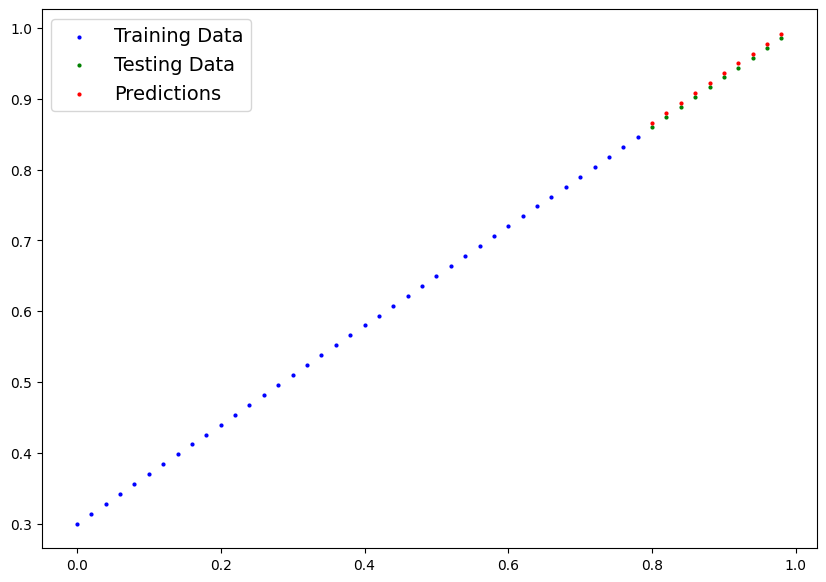

In [25]:
model1.eval() # setting to evaluation mode
with torch.inference_mode(): # always remember to make predictions with inference mode
  y_pred = model1(x_test)
plot_predictions(predictions=y_pred.detach()) # Detach y_pred before passing to plot_predictions

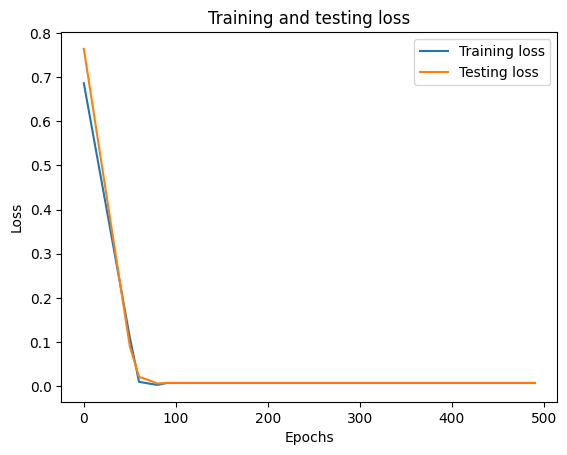

In [26]:
plt.plot(epoch_counts , training_loss_values, label = "Training loss")
plt.plot(epoch_counts , testing_loss_values, label = "Testing loss")
plt.title("Training and testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Not sure why is there a random bump in the testing loss. Maybe because of the radom weights and biases that were initialized because the second time model was initialized and trained, it was fixed.

## Saving and loading models
The three main functions to know for saving and loading models are
1. `torch.save` : Models, tensors and various other Python objects can be saved / exported using this method
2. `torch.load` : Unpickle Python objects to deserialize them and load into the memory. We can also choose the device where the object is loaded
3. `torch.nn.Module.load_state_dict` : loads the models parameters saved in `model.state_dict()` object

### Saving a model's `state_dict`
Steps
1. create a directory to save the model
2. create file path
3. call `torch.save(obj, f)`

In [27]:
from pathlib import Path

In [30]:
# creating directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

In [31]:
# create save path
MODEL_NAME = "01_pytorch_workflow_model1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [32]:
# save the model
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = model1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model1.pth


### Loading saved models
It is recommended to save the `state_dict` rather than an entire model because a model can have various dependencies and might not work in all env as expected.

This is why it is suggested to export the parameters and then load and use them instead. This is done as follows
`torch.nn.Module.load_state_dict(torch.load(f))`

In [33]:
loaded_model1 = LinearRegressionModel() # This is of type torch.nn.Module
loaded_model1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Now I'm testing the loaded model

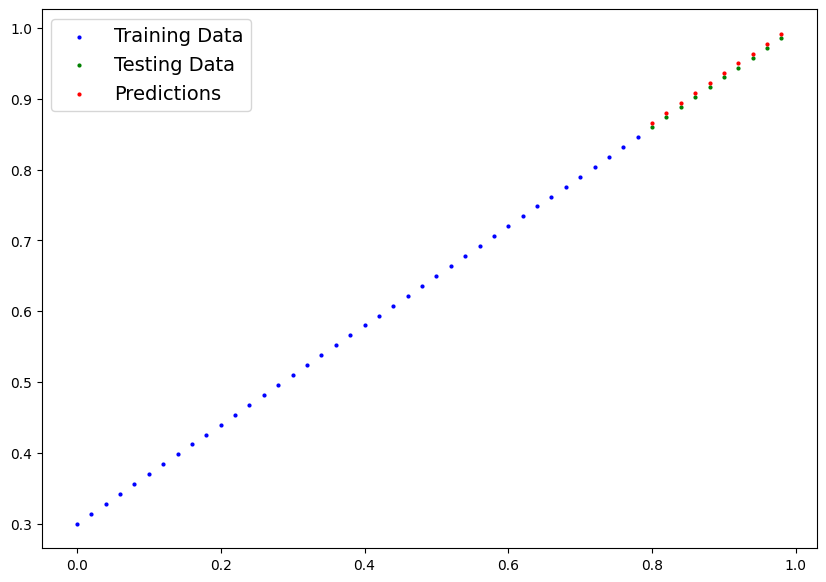

In [34]:
loaded_model1.eval()
with torch.inference_mode():
  y_pred = loaded_model1(x_test)

plot_predictions(predictions=y_pred)

We can see that it had predicted exactly the same way as it did earlier

In [35]:
loaded_model1.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

## Training and testing on GPU